This notebook shows a method to segment embryo membrane images using persistent homology (PH).

The 2D PH-based mask construction part is related to the following code, but this one is simpler.

https://github.com/TopologicalBird/Persistent_Homological_2D_Membrane_Enhancement

After the 2D mask construction, we use 3D PH to detect the centers of the cells.

Using these centers as markers, we can apply the watershed method for 3D segmentation.

The embryo image shown in this notebook was provided by Dr. Dimitri Fabrèges

used in the following article:

https://doi.org/10.1101/2023.01.24.525420

In [1]:
import cv2
import homcloud.interface as hc
import numpy as np
import matplotlib.pyplot as plt
import copy
import napari
from skimage import filters
from skimage.segmentation import watershed
from napari.utils import nbscreenshot

In [2]:
NUMBER=58

In [3]:
image = cv2.imreadmulti("SOME_IMAGE_NAME_HERE"+str(NUMBER)+".tif", flags =cv2.IMREAD_UNCHANGED)
imageSlices=image[1]
viewer = napari.view_image(np.array(imageSlices))

Assistant skips harvesting pyclesperanto as it's not installed.


A 2D slice of the data looks like the following.

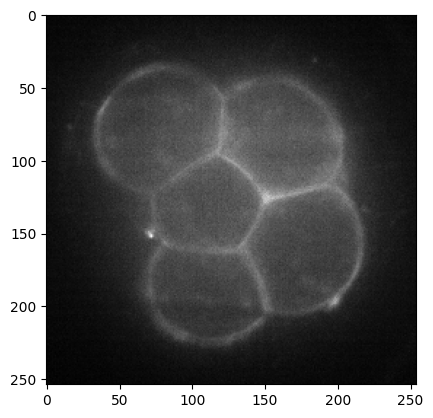

In [4]:
plt.imshow(imageSlices[38],cmap='gray')
plt.show()

Now, we use a ridge filter to enhance the boundaries of cells.

In [5]:
filteredSlices=[]
for i in range (0,len(imageSlices)):
    filtered_img=filters.sato(imageSlices[i],sigmas=range(2,5,1),black_ridges=False,mode='reflect',cval=0)
    filteredSlices.append(filtered_img)
filteredSlices=np.array(filteredSlices)*255/np.max(np.array(filteredSlices))
filteredSlices=np.round(filteredSlices).astype('uint8')

In [6]:
viewer = napari.view_image(filteredSlices)

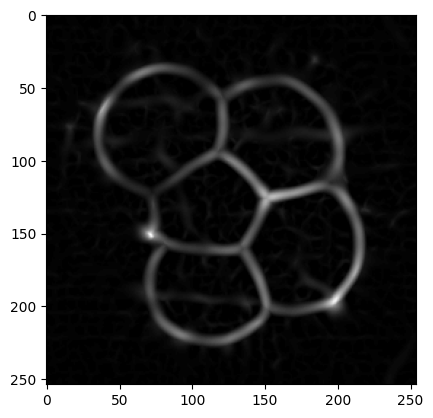

In [7]:
plt.imshow(filteredSlices[38],cmap='gray')
plt.show()

Next, we use grayscale PH to construct a mask of the cells.

In this example, there is some noise inside the cell regions.

Ridge filters detect not only the cell borders but also some interior noise.

If weaker interior signals have some meanings, we can sort the detected structures in the ascending persistence order as in

https://github.com/TopologicalBird/Persistent_Homological_2D_Membrane_Enhancement

On the other hand, as in this case, if we want to erase weaker interior signals,

we can simply draw all the structures, and the exterior ones will remain.

A tip here is to make sure the background has the smallest value. This will send the background into the essential class,

and we can detect the figures as usual nodes in PH.

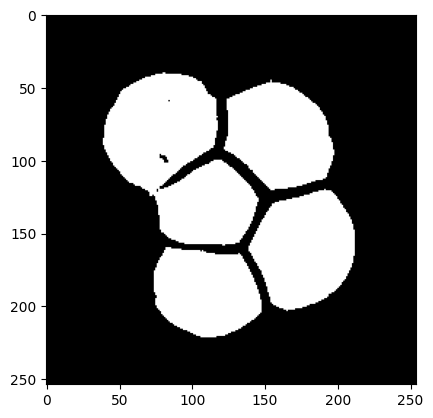

In [8]:
h,w=filteredSlices[0].shape
lifethres=3#####Threshold value for the persistence
volumethres=2000#####Threshold value for the volume size to be detected
too_large_area=20000
pict=filteredSlices[38]
h,w=pict.shape
sample_detected_mask=np.zeros((h,w))
pict_16=copy.deepcopy(pict)
pict_16=pict_16.astype('uint16')
pict_16=pict_16+1
pict_16[1,1]=0####Background should go to the essential class.
hc.BitmapPHTrees.for_bitmap_levelset(pict_16, "sublevel", save_to="grayscale2-tree.pdgm")
phtrees2 = hc.PDList("grayscale2-tree.pdgm").bitmap_phtrees(0)
nodes = [node for node in phtrees2.nodes if node.lifetime() > lifethres and node.death_time() != np.inf and len(node.volume())>volumethres]
for i in range (0,len(nodes)):
    detected_mask=np.zeros((h,w))
    mask_spots=tuple(np.transpose(np.array(nodes[i].volume())).tolist())
    detected_mask[mask_spots]=255
    if len(np.where(detected_mask)[0])<too_large_area and detected_mask[0,0]==0 and detected_mask[h-1,0]==0 and detected_mask[0,w-1]==0 and detected_mask[h-1,w-1]==0:####
        sample_detected_mask[np.where(detected_mask)]=255
plt.imshow(sample_detected_mask,cmap='gray')
plt.show()

We construct masks slice by slice. This will take some time. (Usually about 30 sec-1 min)

In [22]:
%%time
start=21
end=64
h,w=filteredSlices[0].shape
lifethres=3#####Threshold value for the persistence
volumethres=2000#####Threshold value for the volume size to be detected
too_large_area=20000
detected_mask_slices=[np.zeros((h,w)) for t in range (0,len(filteredSlices))]
for alpha in range(start,end):
    print("Processing", alpha, "th Slide-max", end-1)
    pict=filteredSlices[alpha]
    h,w=pict.shape
    pict_16=copy.deepcopy(pict)
    pict_16=pict_16.astype('uint16')
    pict_16=pict_16+1
    pict_16[1,1]=0
    hc.BitmapPHTrees.for_bitmap_levelset(pict_16, "sublevel", save_to="grayscale2-tree.pdgm")
    phtrees2 = hc.PDList("grayscale2-tree.pdgm").bitmap_phtrees(0)
    nodes = [node for node in phtrees2.nodes if node.lifetime() > lifethres and node.death_time() != np.inf and len(node.volume())>volumethres]
    for i in range (0,len(nodes)):
        detected_mask=np.zeros((h,w))
        mask_spots=tuple(np.transpose(np.array(nodes[i].volume())).tolist())
        detected_mask[mask_spots]=255
        if len(np.where(detected_mask)[0])<too_large_area and detected_mask[0,0]==0 and detected_mask[h-1,0]==0 and detected_mask[0,w-1]==0 and detected_mask[h-1,w-1]==0:####
            detected_mask_slices[alpha][np.where(detected_mask)]=255


Processing 21 th Slide-max 63
Processing 22 th Slide-max 63
Processing 23 th Slide-max 63
Processing 24 th Slide-max 63
Processing 25 th Slide-max 63
Processing 26 th Slide-max 63
Processing 27 th Slide-max 63
Processing 28 th Slide-max 63
Processing 29 th Slide-max 63
Processing 30 th Slide-max 63
Processing 31 th Slide-max 63
Processing 32 th Slide-max 63
Processing 33 th Slide-max 63
Processing 34 th Slide-max 63
Processing 35 th Slide-max 63
Processing 36 th Slide-max 63
Processing 37 th Slide-max 63
Processing 38 th Slide-max 63
Processing 39 th Slide-max 63
Processing 40 th Slide-max 63
Processing 41 th Slide-max 63
Processing 42 th Slide-max 63
Processing 43 th Slide-max 63
Processing 44 th Slide-max 63
Processing 45 th Slide-max 63
Processing 46 th Slide-max 63
Processing 47 th Slide-max 63
Processing 48 th Slide-max 63
Processing 49 th Slide-max 63
Processing 50 th Slide-max 63
Processing 51 th Slide-max 63
Processing 52 th Slide-max 63
Processing 53 th Slide-max 63
Processing

In [277]:
viewer = napari.view_image(np.array(detected_mask_slices))

Before moving on to the 3D PH segmentation, we will conduct some noise reduction.

In this case, we will reduce the black pixels inside the mask by focusing on the most external contours.

We can also add some dilation if necessary.

In [23]:
kernel=np.array([[1,1,1],[1,1,1],[1,1,1]],dtype='uint8')
kernel2=np.array([[0,1,0],[1,1,1],[0,1,0]],dtype='uint8')
dilated_mask_slices=[]
for i in range (0,len(detected_mask_slices)):
    detected_mask=detected_mask_slices[i]
    contours,hierarchy =cv2.findContours(detected_mask.astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    external_mask=np.zeros((h,w))
    for j in range (0,len(contours)):
        contour_points=np.array([[contours[j][k][0][1],contours[j][k][0][0]] for k in range (0,len(contours[j]))])
        contour_points_tr=np.transpose(contour_points)
        external_mask[(contour_points_tr[0],contour_points_tr[1])]=255
    Y=external_mask<150
    n_labels, labels,stats,centroids = cv2.connectedComponentsWithStats(Y.astype('uint8'), connectivity=4)
    connected_components_external=np.zeros((h,w))
    for l in range (0,np.max(labels)):
        labelIndex=l+1####
        spots=np.where(labels==labelIndex)
        if len(spots[0])<too_large_area:
            connected_components_external[spots]=255
    dilated_mask=cv2.dilate(connected_components_external,kernel=kernel,iterations=1)
    #dilated_mask=cv2.dilate(dilated_mask,kernel=kernel,iterations=1)
    dilated_mask_slices.append(dilated_mask)

In [11]:
viewer = napari.view_image(np.array(dilated_mask_slices))

In [24]:
dilated_mask_slices=np.array(dilated_mask_slices)

If the resolutions of z axis and xy plane are different, we adjust them as follows.

In [25]:
rep=3
dilated_mask_slices_interpolate=[dilated_mask_slices[int(i/rep)] for i in range (0,rep*len(dilated_mask_slices))]
dilated_mask_slices_interpolate=np.array(dilated_mask_slices_interpolate)

Now, we have a set of masks piled up in 3D space.

We will use 3D PH to detect the cells.

This part is related to 

https://github.com/TopologicalBird/PersistentHomological3DCellDetection

In the above code, our input is the boundary information of the cells. Thus, we used H2 homology.

In our example, we have volume information, so we can use H0 homology.

This part will take some time (usually about 30 sec).

In [26]:
%%time
X=dilated_mask_slices_interpolate>150
pdlist = hc.PDList.from_bitmap_levelset(hc.distance_transform(X, signed=True), save_to="binary-3d"+str(NUMBER)+".pdgm")

CPU times: total: 19 s
Wall time: 33.1 s


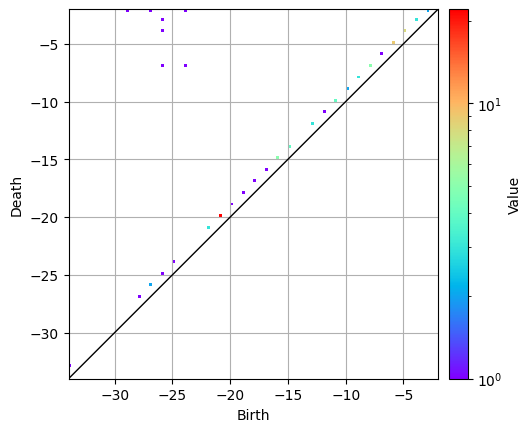

In [27]:
pdlist = hc.PDList("binary-3d"+str(NUMBER)+".pdgm")
pd0 = pdlist.dth_diagram(0)
pd0.histogram().plot(colorbar={"type": "log"})

Now, we can see some birth-death pairs with large persistences and births. These pairs correspond to cells.

In the following part, you can set two parameters, the lifetime threshold value and the birth time threshold value.

Note that in our calculation, the birth time is negative.

In [28]:
largelongpairs=[pair for pair in pd0.pairs() if pair.lifetime()>5 and pair.birth_time()<-10]
largelongpairs

[Pair(-24.0, -7.0),
 Pair(-26.0, -7.0),
 Pair(-26.0, -4.0),
 Pair(-26.0, -3.0),
 Pair(-24.0, -2.0),
 Pair(-29.0, -2.0),
 Pair(-27.0, -2.0)]

You can see in the histogram below that our method successfully separated figures from noise.

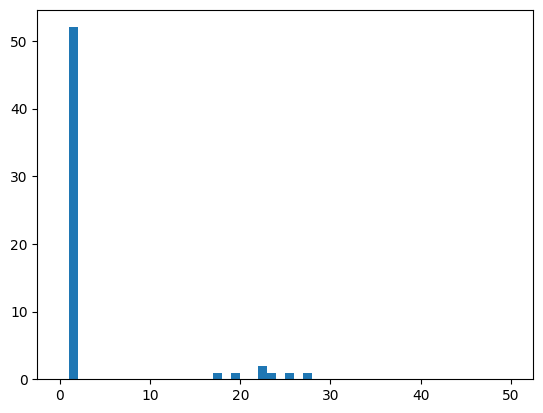

In [29]:
persistence=[pair.lifetime() for pair in pd0.pairs() if pair.birth_time()<-10]
bins=np.linspace(0,50,51)
plt.hist(persistence,bins)
plt.show()

In [30]:
set(persistence)

{1.0, 17.0, 19.0, 22.0, 23.0, 25.0, 27.0}

We use the birth positions of the detected figures as the markers of the watershed method.

Note that one structure is in the essential class.

In [31]:
z,h,w=X.shape
markers=np.zeros((z,h,w))
for i in range (0,len(largelongpairs)):
    print(i)
    pairBP=largelongpairs[i].birth_position
    markers[pairBP[0],pairBP[1],pairBP[2]]=i+2
esspairBP=pd0.essential_birth_positions
markers[esspairBP[0][0],esspairBP[0][1],esspairBP[0][2]]=1
markers=markers.astype('int32')

0
1
2
3
4
5
6


In [32]:
labels = watershed(hc.distance_transform(X, signed=True), markers, mask=X)

In [33]:
viewer = napari.view_image(labels)

We show some screenshots of the results.

The segmentation is successful.

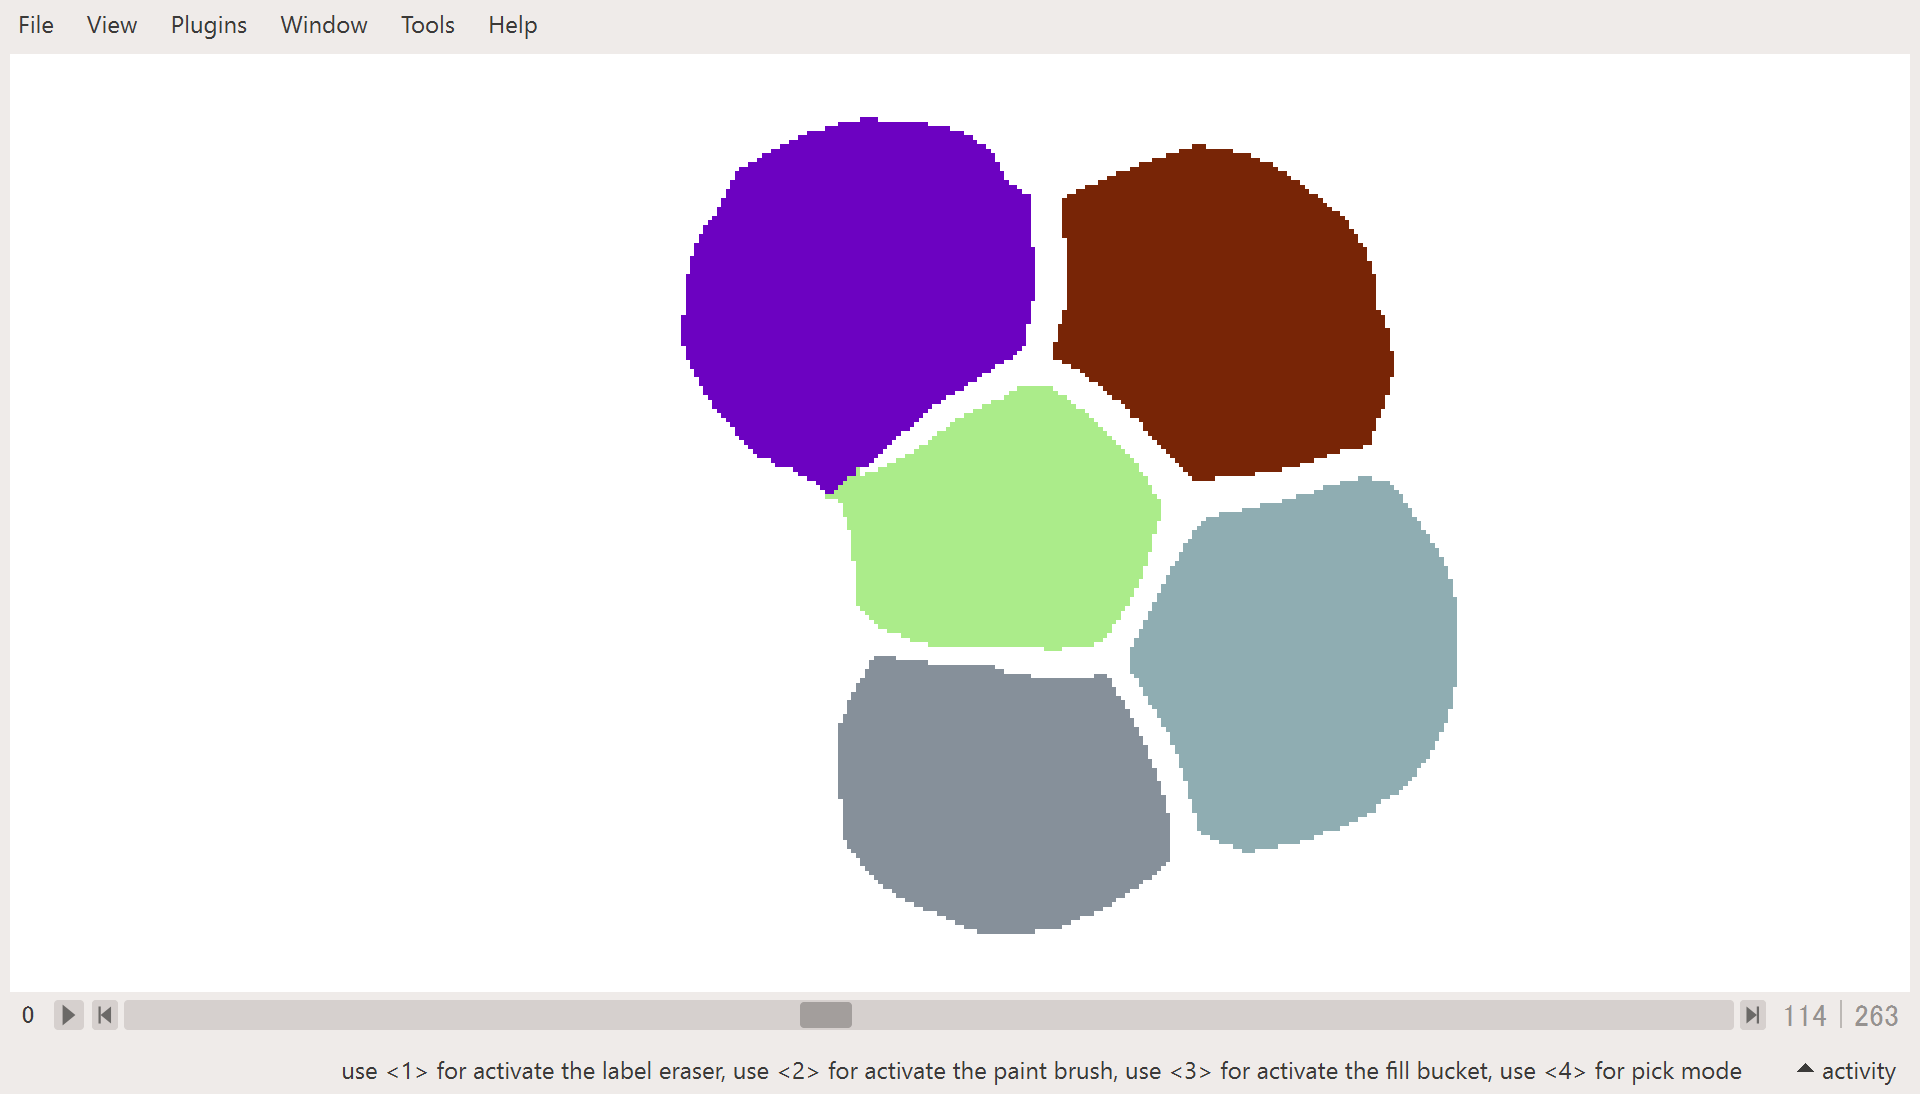

In [43]:
nbscreenshot(viewer)

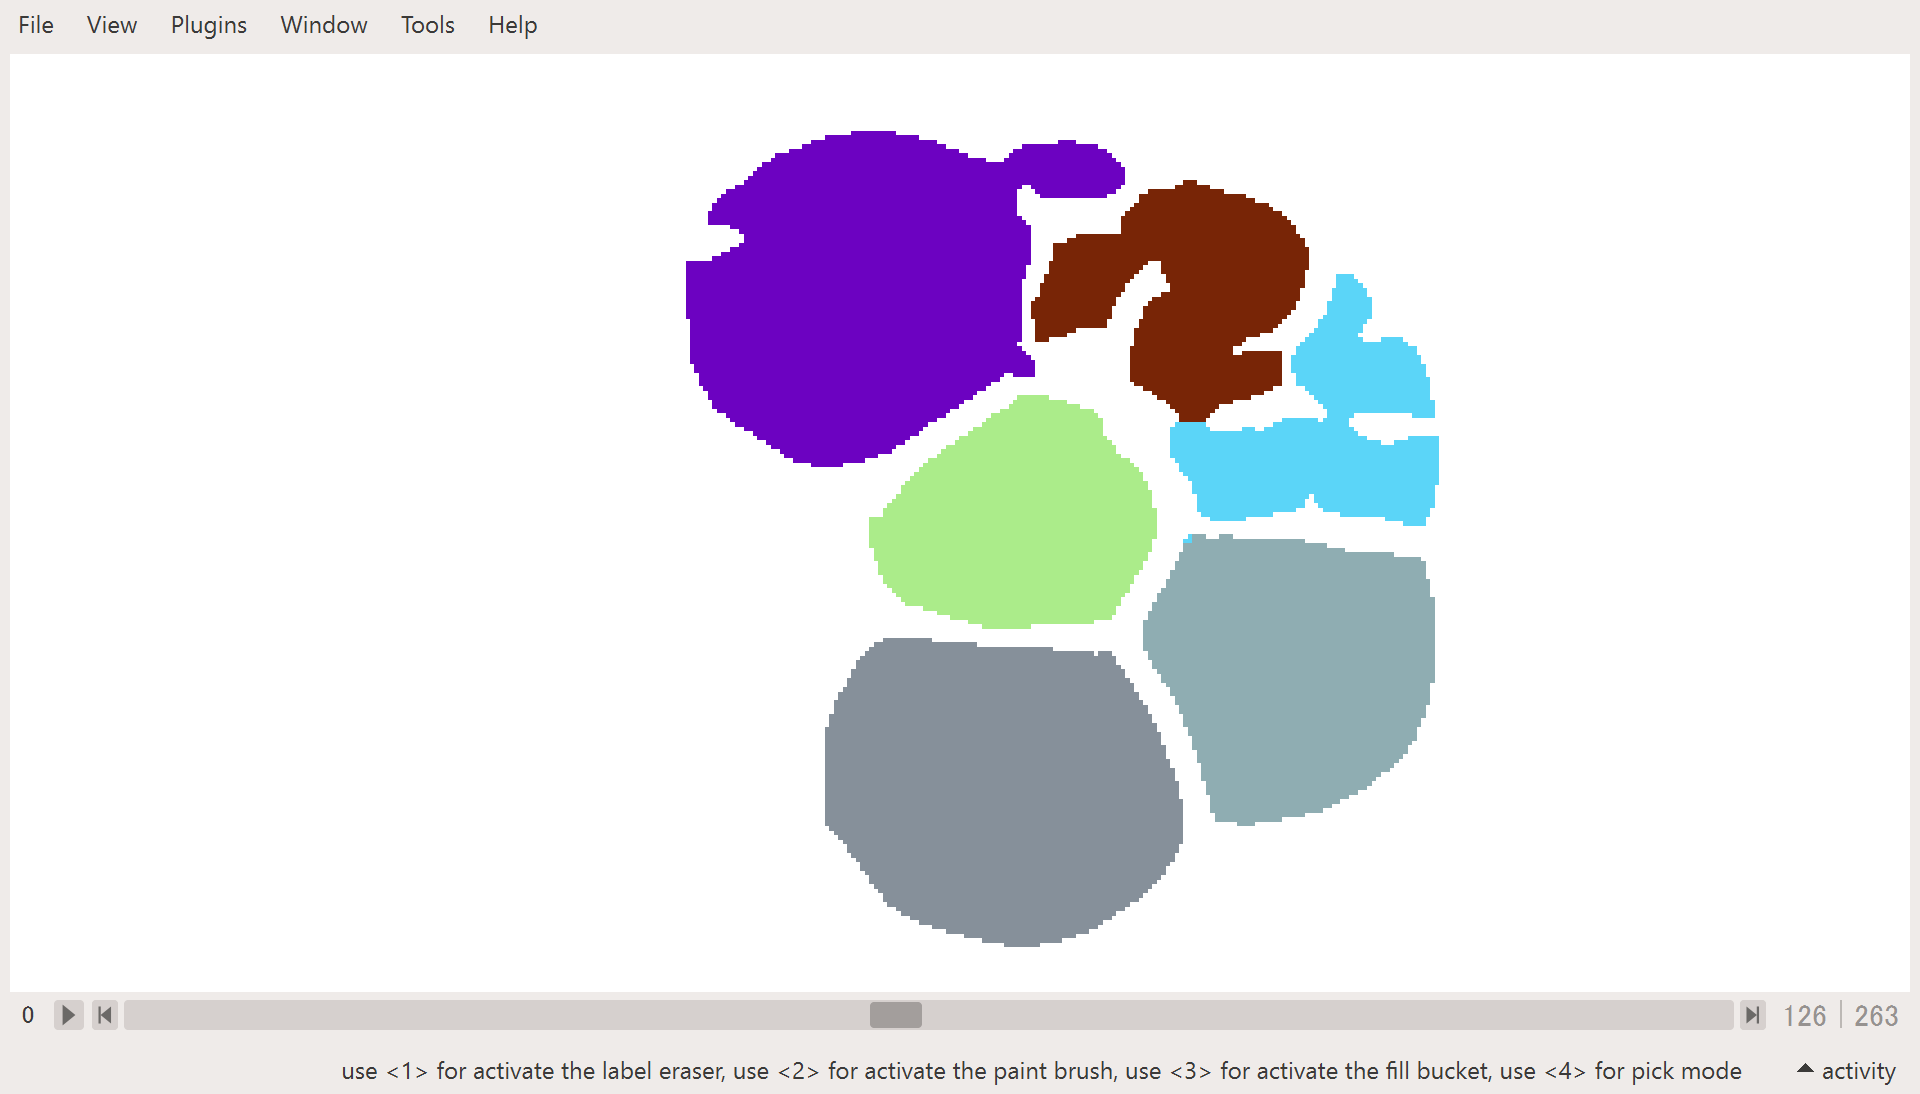

In [44]:
nbscreenshot(viewer)

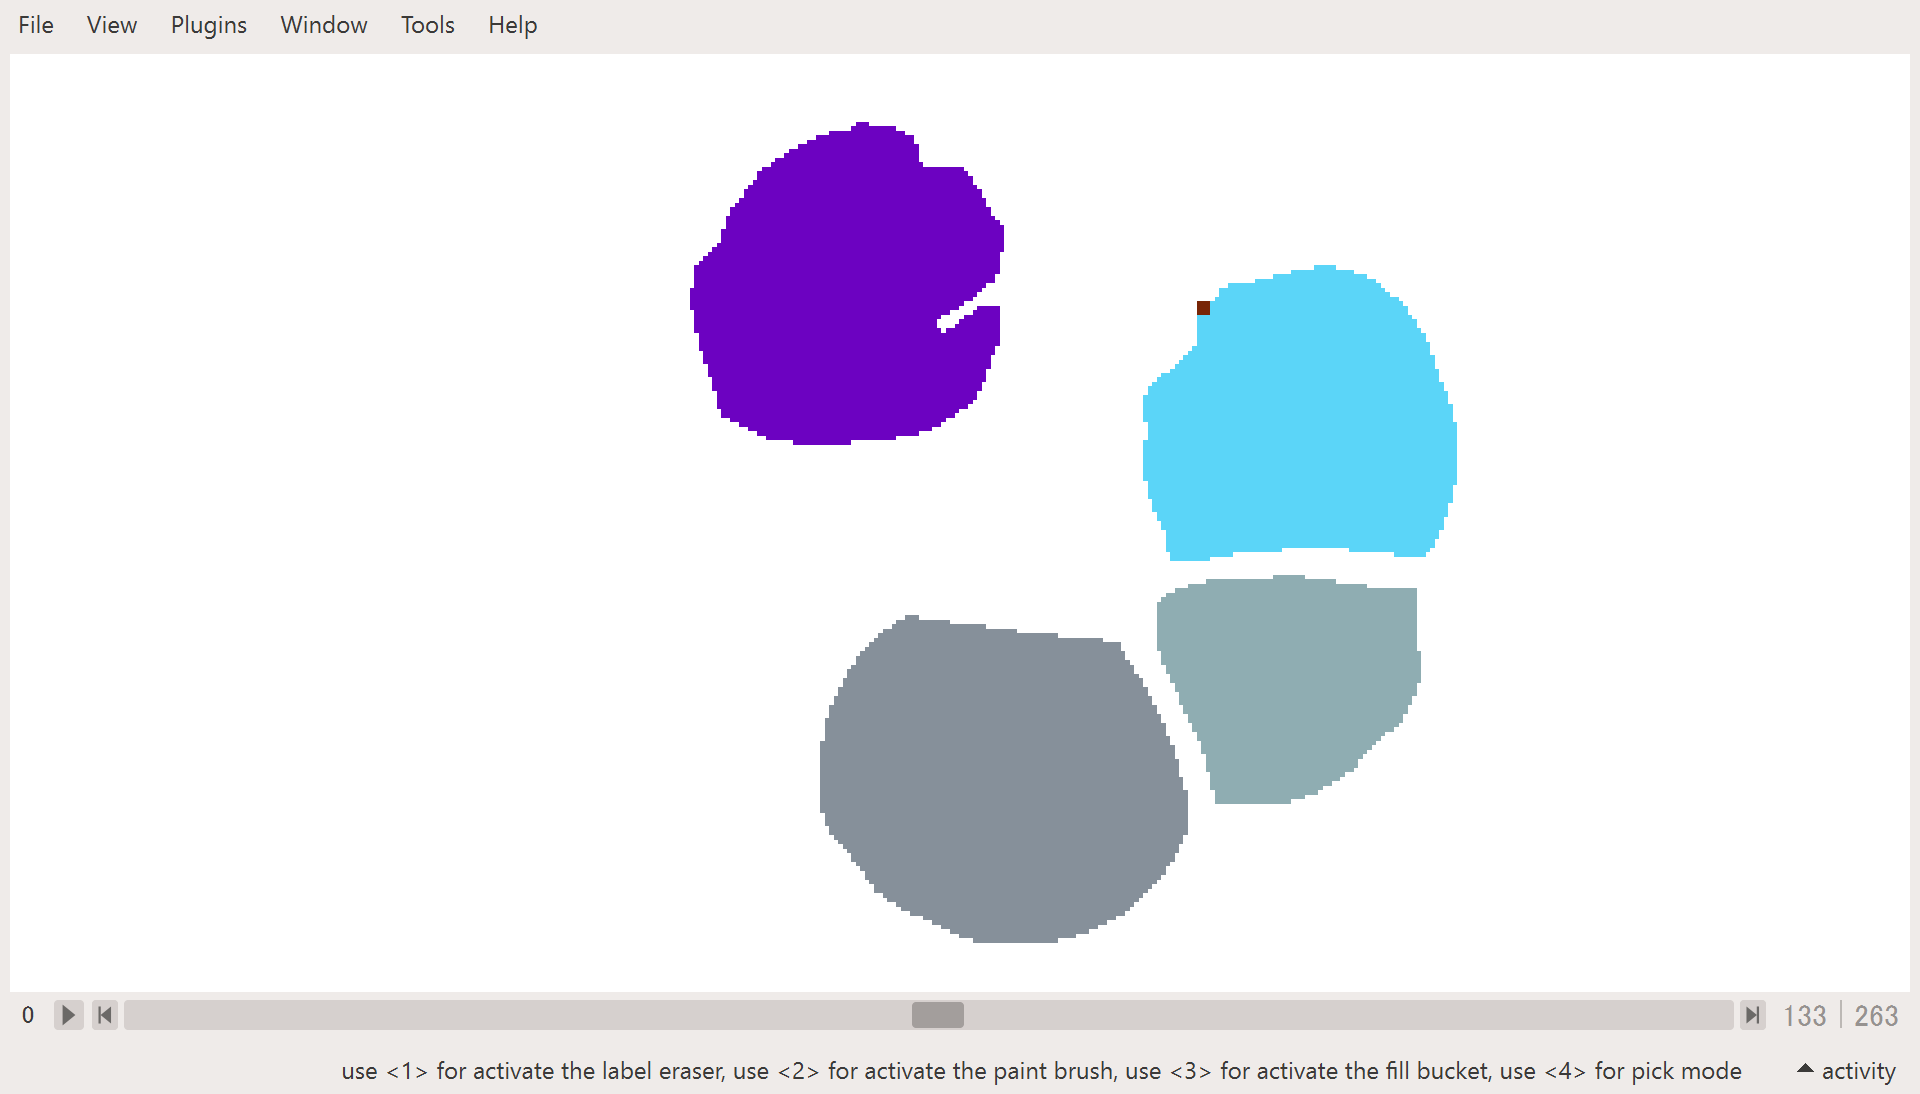

In [45]:
nbscreenshot(viewer)

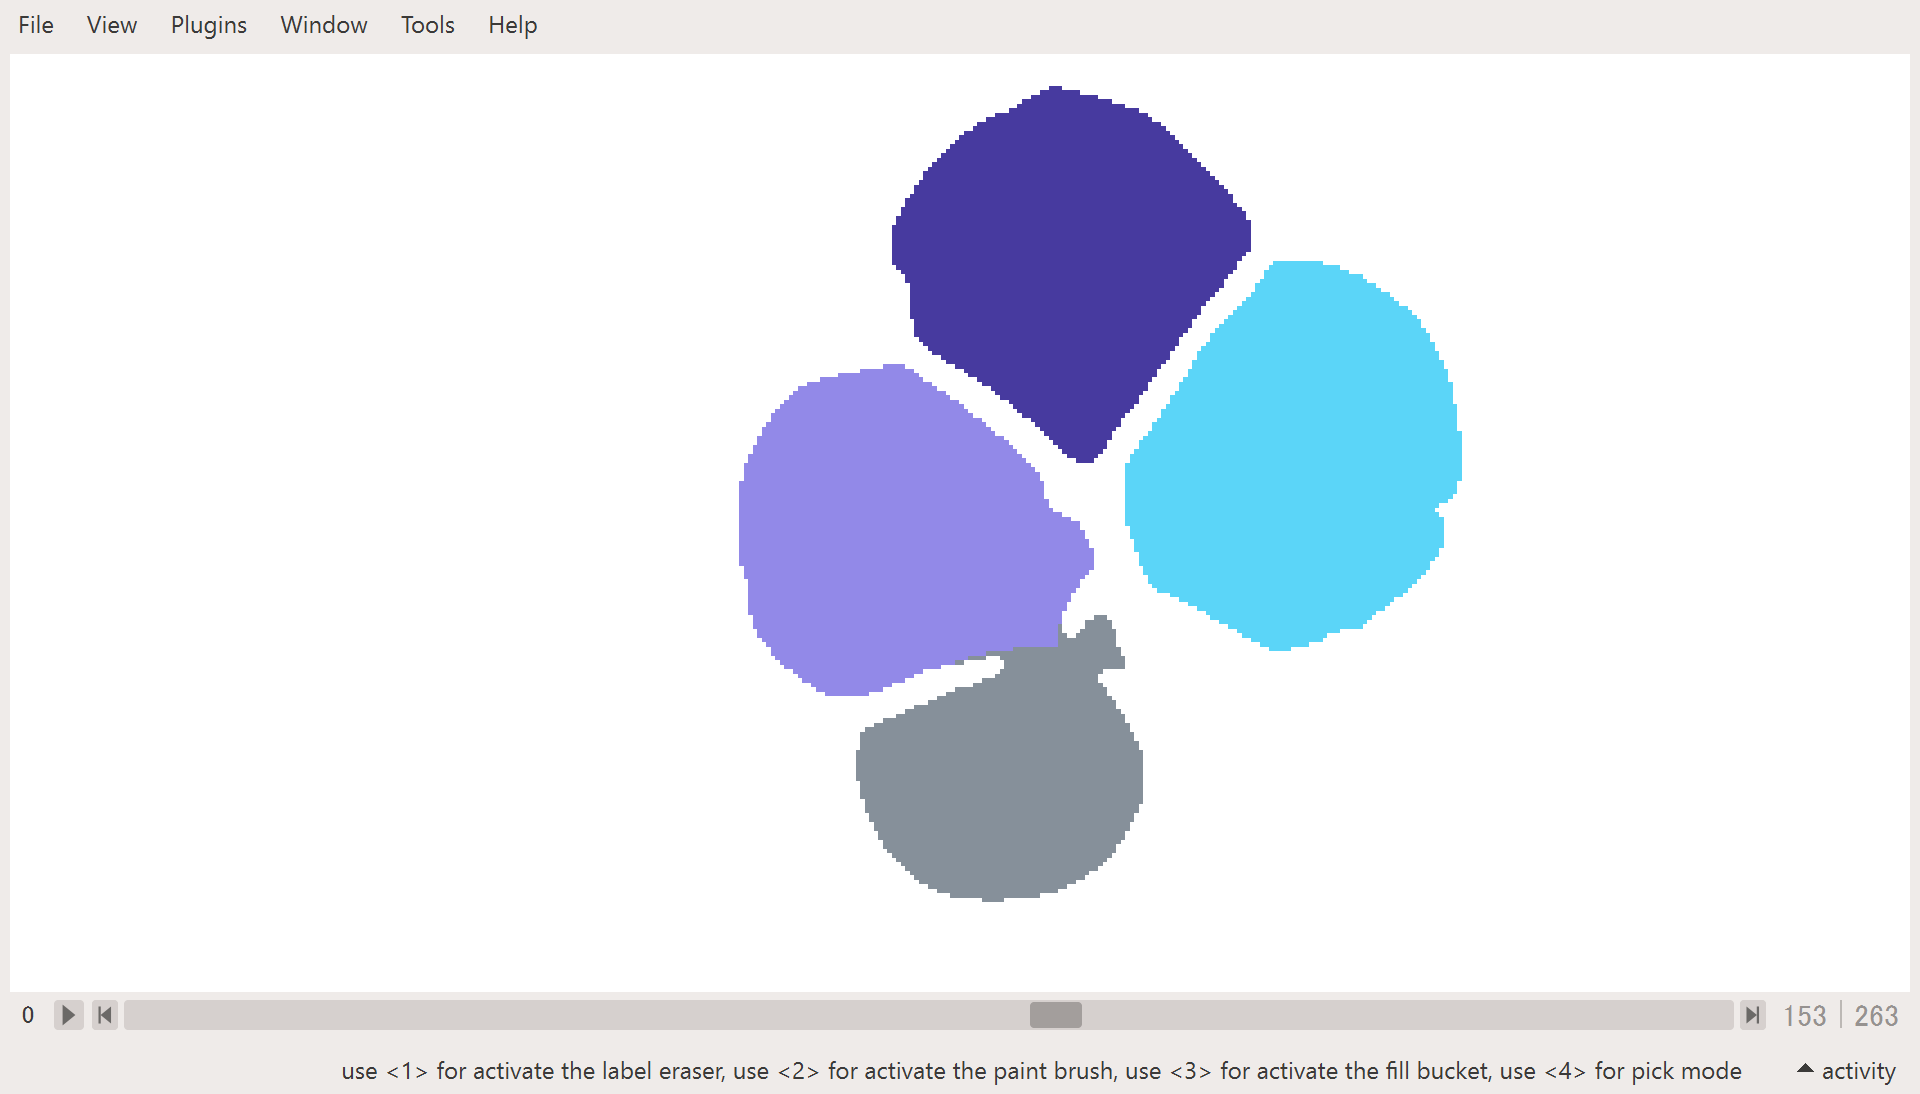

In [46]:
nbscreenshot(viewer)